In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

2023-05-02 09:54:31.294989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 09:54:32.120070: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
2023-05-02 09:54:32.120197: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin

# 1) 로이터 뉴스 데이터 탐색적 분석

In [2]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    # 출현 빈도 상위 몇 위까지의 단어를 불러올지 설정합니다.
    # 100일 경우 출연 빈도 상위 100위까지의 단어를 불러옵니다.
    # 모든 단어를 불러오려면 None으로 설정합니다.
    num_words = None,
    test_split = 0.2
)

print("훈련용 뉴스 기사: {}".format(len(X_train)))
print("테스트용 뉴스 기사: {}".format(len(X_test)))
print("카테고리 개수: {}".format(len(set(y_train))))
print("첫 번째 훈련용 뉴스 기사: ", X_train[0])
print("첫 번째 훈련용 뉴스 기사의 카테고리: ", y_train[0])

훈련용 뉴스 기사: 8982
테스트용 뉴스 기사: 2246
카테고리 개수: 46
첫 번째 훈련용 뉴스 기사:  [1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
첫 번째 훈련용 뉴스 기사의 카테고리:  3


첫 번재 훈련용 뉴스 기사의 데이터는 토큰화와 정수 인코딩을 마친 상태이기 때문에 텍스트가 아니라 정수 리스트입니다.

정수 인코딩 과정에서 단어의 출현 빈도 순위에 따라 정수를 부여하였습니다.

예를 들어 1은 출현 빈도 1위의 단어이며, 27,595는 출현 빈도 27.595위의 단어입니다.

### 훈련용 뉴스 기사의 길이

뉴스 기사의 최대 길이: 2376
뉴스 기사의 평균 길이: 145.5398574927633


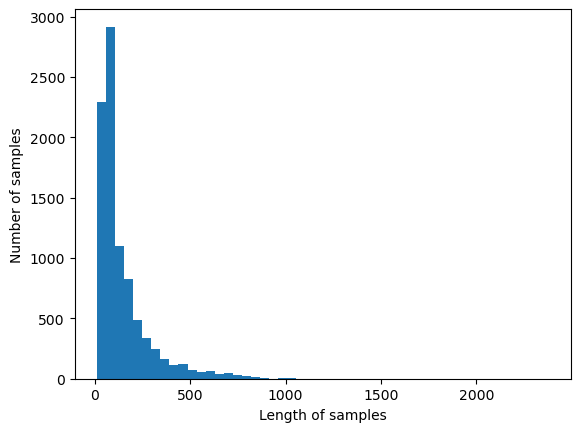

In [3]:
print("뉴스 기사의 최대 길이: {}".format(max(map(len, X_train))))

print("뉴스 기사의 평균 길이: {}".format(sum(map(len, X_train)) / len(X_train)))

plt.hist([len(sample) for sample in X_train], bins = 50)
plt.xlabel("Length of samples")
plt.ylabel("Number of samples")
plt.show()

### 훈련용 뉴스의 카테고리 분포

<AxesSubplot:ylabel='count'>

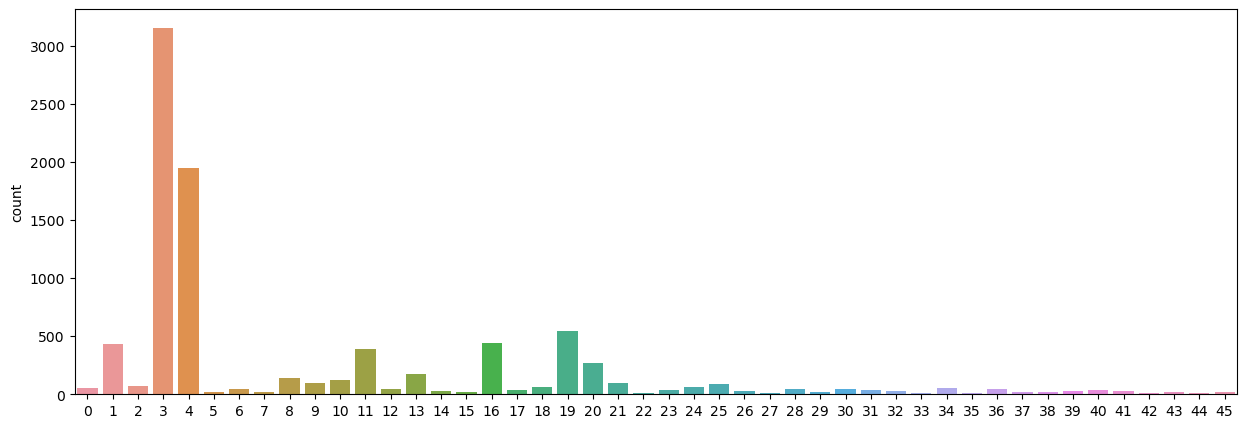

In [4]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x = y_train)

In [5]:
unique_category, counts_category = np.unique(y_train, return_counts = True)

print(np.asarray((unique_category, counts_category)))

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 인덱스에 매핑된 단어 확인

In [6]:
word_to_index = reuters.get_word_index()

print(list(word_to_index.keys())[:10])
print(list(word_to_index.values())[:10])

['mdbl', 'fawc', 'degussa', 'woods', 'hanging', 'localized', 'sation', 'chanthaburi', 'refunding', 'hermann']
[10996, 16260, 12089, 8803, 13796, 20672, 20673, 20675, 10997, 8804]


In [7]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value + 3] = key

### 특별 토큰 추가

인덱스 0: 패딩 토큰

1: 문장 시작 토큰 sos

2: OVV 토큰 unk

In [8]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

In [9]:
print("출현 빈도 1위 단어: {}".format(index_to_word[1 + 3]))
print("출현 빈도 100위 단어: {}".format(index_to_word[100 + 3]))

출현 빈도 1위 단어: the
출현 빈도 100위 단어: group


특별 토큰을 제외하고 출현 빈도 1위의 단어를 구하기 위해 4번째 인덱스에 매핑된 단어를 구합니다.

### 첫 번째 훈련용 뉴스 기사를 단어로 복원

In [10]:
print(" ".join([index_to_word[index] for index in X_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


전처리한 문장이기 때문에 완전한 문장으로 복원되지 않습니다.

# 2) LSTM으로 로이터 뉴스 분류